First, create a quantum circuit using the QCircuit class:

In [2]:
from padqc import QCircuit

circuit = QCircuit()

You can then add registers to the circuit:

In [3]:
qr1 = circuit.add_q_register('qr1', 2)
qr2 = circuit.add_q_register('qr2', 2)

cr = circuit.add_c_register('cr', 4)

And apply some gates:

In [4]:
# Hadamard gate on qubit 0 of quantum register qr1
circuit.h(qr1[0])

# CNOT gate with qubit 0 of quantum register qr1 
# controlling qubit 1 of quantum register qr2
circuit.cx(qr1[0], qr2[1])

# Measuring qubit 0 of qr1 on classical bit 0 of classical register cr
circuit.measure(qr1[0], cr[0])

Now let us create a circuit with a **custom gate**:

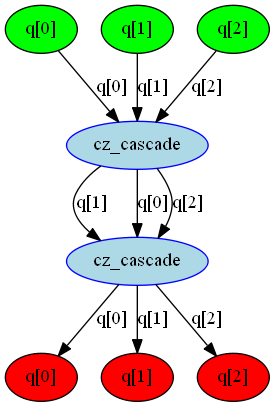

In [5]:
from padqc import CompositeGate

# Controlled z between qubit a and b
cz = CompositeGate('cz')
cz.add_gate('h', q_args=['b'])
cz.add_gate('cx', q_args=['a', 'b'])
cz.add_gate('h', q_args=['b'])

# Cascade of cz gate
cz_cascade = CompositeGate('cz_cascade')
cz_cascade.add_gate(cz, q_args=['a', 'b'], mapping={'a': 'a', 'b': 'b'})
cz_cascade.add_gate(cz, q_args=['a', 'c'], mapping={'a': 'a', 'c': 'b'})

qc = QCircuit()

qr = qc.add_q_register('q', 3)

# Apply the cz cascade two times
qc.composite_gate(cz_cascade, a=qr[0], b=qr[1], c=qr[2])
qc.composite_gate(cz_cascade, a=qr[0], b=qr[1], c=qr[2])

# Visualize circuit as a DAG
from padqc.tools import circuit_drawer
circuit_drawer(qc, show=True)

To compile a circuit you have to use the *compile()* function, which takes four arguments:
- q_circuit (QCircuit): the circuit to be compiled
- steps (list): a list of steps to follow for the compilation. Steps are executed in the order they appear in the list. Defaults to [Patterns(), CancelH(), CancelCx()]
- iterate (bool): if set to True, cancellation steps will be executed recursively until no further cancellation can be achieved. Defaults to False
- explicit (bool): if set to True will execute steps in the order they appear in *steps*. Defaults to False

The available steps are:
- ChainLayout: maps the qubits in the coupling map to a nearest-neighbor sequence of qubits
- Decompose: decomposes every composite gate in its constituent gates
- CancelH: cancels consecutive double Hadamard gates
- CancelCx: cancels consecutive double CNOTs acting on the same qubits
- Patterns: recognizes CNOT cascades and inverse CNOT cascades, decomposing them into nearest-neighbor CNOT sequences
- DeterministicSwap: maps the qubits in the circuit to a nearest-neighbor sequence of qubits in the coupling map, denoted as a *chain*, and adopts a deterministic SWAP strategy when needed

You can use the compile() function as follows:

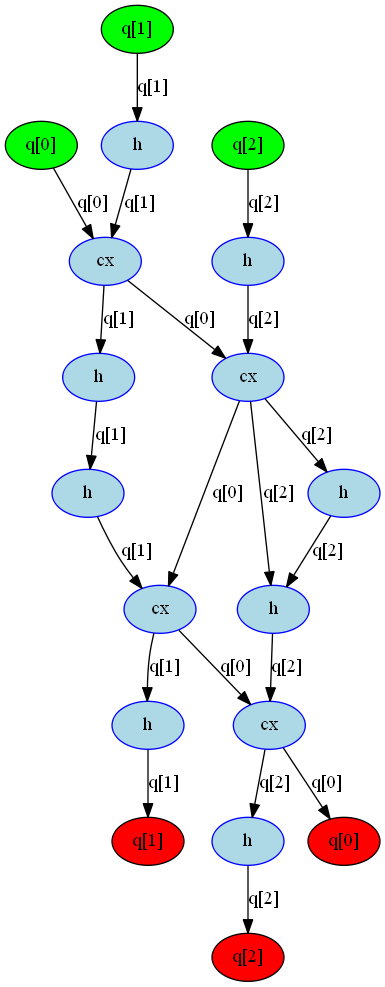

In [5]:
# Using the circuit from the previous example
from padqc import compile
from padqc.steps import Decompose, CancelCx

compile(qc, steps=[CancelCx(), Decompose()])
from padqc.tools import circuit_drawer
circuit_drawer(qc, show=True)

Steps are divided into three categories: 
- AnalysisStep: they do not modify the circuit, like Chainlayout()
- TransformationStep: they modify the circuit exploiting two-qubit gates patterns
- CancellationStep: they modify the circuit by removing redundant gates, like CancelH() and CancelCx()
- CompilingStep: they modify the circuit to optimize gates with respect to the coupling map, like Patterns() and DeterministicSwap()

Steps are executed in the following order:
1. AnalisysStep
2. TransformationStep
3. CompilingStep
4. CancellationStep

You can change this rule by setting *explicit=True* in the *compile()* function to execute them in the order they appear in the *steps* list.

CancellationSteps will be executed only once, if you believe that further cancellation are possible, you can set *iterate=True* to execute them recursively until no more cancellation can be done.

In [6]:
from padqc import compile
from padqc.steps import Decompose, CancelH, ChainLayout, Patterns, CancelCx

coupling_map = [(0, 1), (1, 2)]

compile(qc, steps=[ChainLayout(coupling_map=coupling_map), Patterns(), CancelH(), CancelCx(), Decompose()], iterate=True)

If you visualize the circuit, you will see that double Hadamard gates have been cancelled.

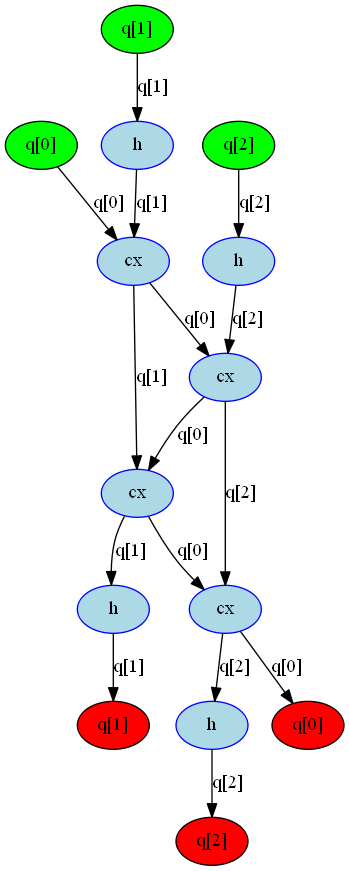

In [7]:
from padqc.tools import circuit_drawer
circuit_drawer(qc, show=True)

For further information and details, see also the code docstrings.

# Third party API compatibility

To make padqc compatible with other APIs and tools, you can convert a *QCircuit*
to a [QASM](https://github.com/Qiskit/openqasm) string.

In [6]:
from padqc.converters import qasm_from_circuit

qc = QCircuit()
qr = qc.add_q_register('qr', 3)
cr = qc.add_c_register('cr', 3)

qc.composite_gate(cz_cascade, a=qr[0], b=qr[1], c=qr[2])

qc.measure(qr, cr)

qasm = qasm_from_circuit(qc)
# You can also convert a qasm to a QCircuit object using circuit_from_qasm()
print(qasm)

# You can retrieve the initial layout of logical qubits to qubits in the coupling map 
# as a list where at index i you will find the physical qubit associated with the i-th logical qubit
initial_layout = qc.properties['layout']

OPENQASM 2.0;
include "qelib1.inc";
qreg qr[3];
creg cr[3];
u3(pi/2,0,pi) qr[1];
cx qr[0],qr[1];
u3(pi/2,0,pi) qr[1];
u3(pi/2,0,pi) qr[2];
cx qr[0],qr[2];
u3(pi/2,0,pi) qr[2];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];
measure qr[2] -> cr[2];

